# Choroid Plexus Segmentation Training via Auto3DSeg

This time use just flair instead of the 2 channel t1_flair

In [1]:
import os
import json
import nibabel as nib
import nibabel as nibabel
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob
import random
from monai.apps.auto3dseg import AutoRunner
from monai.config import print_config
from mri_preproc.paths import hemond_data, init_paths
import importlib
from dataclasses import asdict

print_config()

MONAI version: 1.3.2
Numpy version: 1.26.4
Pytorch version: 2.3.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /home/<username>/.virtualenvs/monai/lib/python3.12/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.4.0
Nibabel version: 5.2.1
scikit-image version: 0.24.0
scipy version: 1.14.0
Pillow version: 10.4.0
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.18.1+cu121
tqdm version: 4.66.4
lmdb version: 1.5.1
psutil version: 6.0.0
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.42.4
mlflow version: 2.14.3
pynrrd version: 1.0.0
clearml version: 1.16.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
init_paths.main()
importlib.reload(hemond_data)

<module 'mri_preproc.paths.hemond_data' from '/home/hemondlab/Dev/ms_mri/mri_preproc/paths/hemond_data.py'>

In [3]:
cwd = os.getcwd()
cwd

'/home/hemondlab/Dev/ms_mri/monai_analysis/choroid2'

## Prep the database

Get the data and labels organized

In [4]:
dataroot = "/home/hemondlab/3Tpioneer_bids"
work_dir = "/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2"
dataset = hemond_data.scan_3Tpioneer_bids(dataroot, "flair", "choroid_t1_flair")
omit_subs = []

In [5]:
dataset = [data for data in dataset if data.label is not None and data.subid not in omit_subs]
print(f"{len(dataset)} labeled scans")

37 labeled scans


In [11]:
test_frac = 0.2
dataset = hemond_data.assign_conditions(dataset, test_frac)
dataset[1]

Scan(subid='ms1518', date='20220216', root=PosixPath('/home/hemondlab/3Tpioneer_bids/sub-ms1518/ses-20220216'), image=PosixPath('/home/hemondlab/3Tpioneer_bids/sub-ms1518/ses-20220216/flair.nii.gz'), label=PosixPath('/home/hemondlab/3Tpioneer_bids/sub-ms1518/ses-20220216/choroid_t1_flair.nii.gz'), cond='tr')

## Review

In [12]:
def display_slices(scan):
    img1 = nibabel.load(scan.image)
    img2 = nibabel.load(scan.label)

    data1 = img1.get_fdata()[:,:,:]
    data2 = img2.get_fdata()

    slice_sums = np.sum(data2, axis=(0, 1))
    
    print(slice_sums)

    max_slice_index = np.argmax(slice_sums)
    print(f"Max slice: {max_slice_index}")

    slice1 = data1[:, :, max_slice_index]
    slice2 = data2[:, :, max_slice_index]    

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(slice1, cmap='gray')
    plt.title(f"Image 1 - Slice {max_slice_index}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(slice2, cmap='gray')
    plt.title(f"Image 2 - Slice {max_slice_index}")
    plt.axis('off')
    plt.show()


In [13]:
img2 = nibabel.load(dataset[0].label)
data2 = img2.get_fdata()

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   2.  67.  86.  53.  74.  61.  69.  85.  74.
  66.  87.  79.  96. 103. 105. 104.  73.  98. 110.  83.  87.  84.  74.
 101.  58.  75.  72. 103.  75. 135. 109.  40.  18.   0.   0.   0.   0.
   0. 

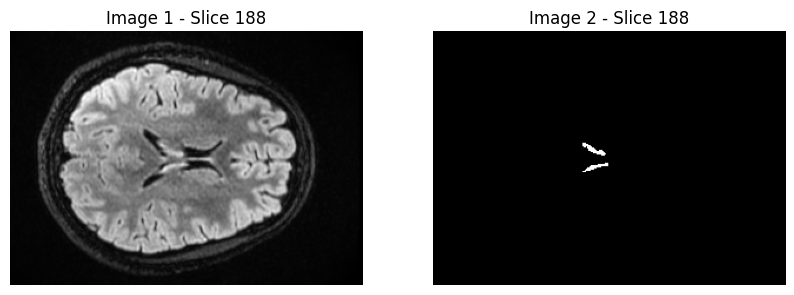

In [14]:
display_slices(dataset[20])

In [15]:
train_data = []
test_data = []
for scan in dataset:
    if scan.cond == 'tr' and scan.has_label():
        train_data.append({"image": str(scan.image), "label": str(scan.label)})
    elif scan.cond == 'ts' and scan.has_label():
        test_data.append({"image": str(scan.image), "label": str(scan.label)})


print(f"Train num total: {len(train_data)}")
print(f"Test num: {len(test_data)}")

Train num total: 30
Test num: 7


In [16]:
n_folds = 5
datalist = {
    "testing": test_data,
    "training": [{"fold": i % n_folds, "image": c["image"], "label": c["label"]} for i,c in enumerate(train_data)]
}

In [17]:
datalist_file = os.path.join(cwd, "datalist.json")
with open(datalist_file, 'w') as f:
    json.dump(datalist, f, indent=4)
datalist

{'testing': [{'image': '/home/hemondlab/3Tpioneer_bids/sub-ms1080/ses-20180416/flair.nii.gz',
   'label': '/home/hemondlab/3Tpioneer_bids/sub-ms1080/ses-20180416/choroid_t1_flair.nii.gz'},
  {'image': '/home/hemondlab/3Tpioneer_bids/sub-ms1033/ses-20171117/flair.nii.gz',
   'label': '/home/hemondlab/3Tpioneer_bids/sub-ms1033/ses-20171117/choroid_t1_flair.nii.gz'},
  {'image': '/home/hemondlab/3Tpioneer_bids/sub-ms1259/ses-20200803/flair.nii.gz',
   'label': '/home/hemondlab/3Tpioneer_bids/sub-ms1259/ses-20200803/choroid_t1_flair.nii.gz'},
  {'image': '/home/hemondlab/3Tpioneer_bids/sub-ms1265/ses-20180127/flair.nii.gz',
   'label': '/home/hemondlab/3Tpioneer_bids/sub-ms1265/ses-20180127/choroid_t1_flair.nii.gz'},
  {'image': '/home/hemondlab/3Tpioneer_bids/sub-ms2144/ses-20190422/flair.nii.gz',
   'label': '/home/hemondlab/3Tpioneer_bids/sub-ms2144/ses-20190422/choroid_t1_flair.nii.gz'},
  {'image': '/home/hemondlab/3Tpioneer_bids/sub-ms1119/ses-20161010/flair.nii.gz',
   'label': '/ho

In [18]:
# work_dir = "/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir6"
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

datalist_file = os.path.join(work_dir, "datalist.json")
with open(datalist_file, "w") as f:
    json.dump(datalist, f)

In [19]:
runner = AutoRunner(
    work_dir=work_dir,
    algos=["swinunetr"],
    input={
        "modality": "MRI",
        "datalist": datalist_file,
        "dataroot": dataroot,
    },
)

2024-09-19 17:17:53,439 - INFO - AutoRunner using work directory /home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2
2024-09-19 17:17:53,440 - INFO - Found num_fold 5 based on the input datalist /home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/datalist.json.
2024-09-19 17:17:53,441 - INFO - Setting num_fold 5 based on the input datalist /home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/datalist.json.
2024-09-19 17:17:53,441 - INFO - Using user defined command running prefix , will override other settings


In [20]:
max_epochs = 100

train_param = {
    "num_epochs_per_validation": 1,
    #"num_images_per_batch": 2,
    "num_epochs": max_epochs,
    "num_warmup_epochs": 1,
}
runner.set_training_params(train_param)

In [21]:
runner.run()

2024-09-19 17:25:32,946 - INFO - Running data analysis...
2024-09-19 17:25:32,947 - INFO - Found 1 GPUs for data analyzing!


100%|██████████| 30/30 [00:12<00:00,  2.32it/s]

2024-09-19 17:25:45,906 - INFO - Data spacing is not completely uniform. MONAI transforms may provide unexpected result
2024-09-19 17:25:45,907 - INFO - Writing data stats to /home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/datastats.yaml.
2024-09-19 17:25:45,912 - INFO - Writing by-case data stats to /home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/datastats_by_case.yaml, this may take a while.
2024-09-19 17:25:45,984 - INFO - BundleGen from https://github.com/Project-MONAI/research-contributions/releases/download/algo_templates/e4cf5a1.tar.gz



algo_templates.tar.gz: 104kB [00:00, 429kB/s]                              

2024-09-19 17:25:46,235 - INFO - Downloaded: /tmp/tmpyuovapf0/algo_templates.tar.gz
2024-09-19 17:25:46,235 - INFO - Expected md5 is None, skip md5 check for file /tmp/tmpyuovapf0/algo_templates.tar.gz.
2024-09-19 17:25:46,236 - INFO - Writing into directory: /home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2.
2024-09-19 17:25:46,280 - INFO - Generated:/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_0
2024-09-19 17:25:46,304 - INFO - Generated:/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_1
2024-09-19 17:25:46,328 - INFO - Generated:/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_2
2024-09-19 17:25:46,353 - INFO - Generated:/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_3
2024-09-19 17:25:46,377 - INFO - Generated:/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_4
2024-09-19 17:25:46,398 - INFO - ['python', '/home/hemondlab/D

2024-09-19 17:25:51,932 - INFO - Downloaded: /home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_0/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt
2024-09-19 17:25:51,933 - INFO - Expected md5 is None, skip md5 check for file /home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_0/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt.


2024/09/19 17:25:52 INFO mlflow.tracking.fluent: Experiment with name 'Auto3DSeg' does not exist. Creating a new experiment.
swinunetr_0 - training ...:  75%|███████▌  | 75/100 [43:14<14:24, 34.59s/round]  
2024-09-19 18:12:34,995 - WARNING - swinunetr_0 - training: finished with early stop


2024-09-19 18:12:36,269 - INFO - ['python', '/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_1/scripts/train.py', 'run', "--config_file='/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_1/configs/hyper_parameters.yaml,/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_1/configs/network.yaml,/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_1/configs/transforms_infer.yaml,/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_1/configs/transforms_train.yaml,/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_1/configs/transforms_validate.yaml'", '--num_epochs_per_validation=1', '--num_epochs=100', '--num_warmup_epochs=1']
2024-09-19 18:12:41,318 - INFO - Downloaded: /home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_1/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt
2024-09-19 18:12:41,318 -

2024/09/19 18:12:41 INFO mlflow.tracking.fluent: Experiment with name 'Auto3DSeg' does not exist. Creating a new experiment.
swinunetr_1 - training ...:  79%|███████▉  | 79/100 [46:09<12:16, 35.06s/round]
2024-09-19 19:02:26,863 - WARNING - swinunetr_1 - training: finished with early stop


2024-09-19 19:02:27,822 - INFO - ['python', '/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_2/scripts/train.py', 'run', "--config_file='/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_2/configs/hyper_parameters.yaml,/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_2/configs/network.yaml,/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_2/configs/transforms_infer.yaml,/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_2/configs/transforms_train.yaml,/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_2/configs/transforms_validate.yaml'", '--num_epochs_per_validation=1', '--num_epochs=100', '--num_warmup_epochs=1']
2024-09-19 19:02:33,024 - INFO - Downloaded: /home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_2/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt
2024-09-19 19:02:33,024 -

2024/09/19 19:02:33 INFO mlflow.tracking.fluent: Experiment with name 'Auto3DSeg' does not exist. Creating a new experiment.
swinunetr_2 - training ...:  79%|███████▉  | 79/100 [46:05<12:15, 35.01s/round]
2024-09-19 19:52:00,674 - WARNING - swinunetr_2 - training: finished with early stop


2024-09-19 19:52:01,615 - INFO - ['python', '/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_3/scripts/train.py', 'run', "--config_file='/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_3/configs/hyper_parameters.yaml,/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_3/configs/network.yaml,/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_3/configs/transforms_infer.yaml,/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_3/configs/transforms_train.yaml,/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_3/configs/transforms_validate.yaml'", '--num_epochs_per_validation=1', '--num_epochs=100', '--num_warmup_epochs=1']
2024-09-19 19:52:06,838 - INFO - Downloaded: /home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_3/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt
2024-09-19 19:52:06,838 -

2024/09/19 19:52:06 INFO mlflow.tracking.fluent: Experiment with name 'Auto3DSeg' does not exist. Creating a new experiment.
swinunetr_3 - training ...:  76%|███████▌  | 76/100 [42:55<13:33, 33.88s/round]
2024-09-19 20:38:29,916 - WARNING - swinunetr_3 - training: finished with early stop


2024-09-19 20:38:30,852 - INFO - ['python', '/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_4/scripts/train.py', 'run', "--config_file='/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_4/configs/hyper_parameters.yaml,/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_4/configs/network.yaml,/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_4/configs/transforms_infer.yaml,/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_4/configs/transforms_train.yaml,/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_4/configs/transforms_validate.yaml'", '--num_epochs_per_validation=1', '--num_epochs=100', '--num_warmup_epochs=1']
2024-09-19 20:38:36,298 - INFO - Downloaded: /home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/swinunetr_4/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt
2024-09-19 20:38:36,298 -

2024/09/19 20:38:36 INFO mlflow.tracking.fluent: Experiment with name 'Auto3DSeg' does not exist. Creating a new experiment.
swinunetr_4 - training ...:  79%|███████▉  | 79/100 [46:15<12:17, 35.13s/round] 
2024-09-19 21:28:20,264 - WARNING - swinunetr_4 - training: finished with early stop


2024-09-19 21:28:21,218 - INFO - Ensembling using single GPU!
2024-09-19 21:28:21,218 - INFO - The output_dir is not specified. /home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/ensemble_output will be used to save ensemble predictions.
2024-09-19 21:28:21,219 - INFO - Directory /home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/ensemble_output is created to save ensemble predictions
2024-09-19 21:28:21,245 - INFO - Auto3Dseg picked the following networks to ensemble:
2024-09-19 21:28:21,245 - INFO - swinunetr_0
2024-09-19 21:28:21,246 - INFO - swinunetr_1
2024-09-19 21:28:21,246 - INFO - swinunetr_2
2024-09-19 21:28:21,246 - INFO - swinunetr_3
2024-09-19 21:28:21,246 - INFO - swinunetr_4
2024-09-19 21:28:21,246 - INFO - Auto3Dseg ensemble prediction outputs will be saved in /home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir_choroid2/ensemble_output.


Ensembling (rank 0)...: 100%|██████████| 7/7 [20:46<00:00, 178.08s/it]
2024-09-19 21:49:07,848 - INFO - Auto3Dseg pipeline is completed successfully.


In [30]:
datalist['training'][48]

{'fold': 3,
 'image': '/mnt/h/3Tpioneer_bids/sub-ms1196/ses-20161004/t1.nii.gz',
 'label': '/mnt/h/3Tpioneer_bids/sub-ms1196/ses-20161004/pituitary.nii.gz'}

In [29]:
scan_path = "/mnt/t/Data/3Tpioneer_bids/sub-ms1001/ses-20170215/proc/lesion_index.t3m20-mni_reg.nii.gz"
img = nib.load(scan_path)
